In [1]:
%pip install pandas nltk sentence-transformers scipy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pqbsbk/german-news-dataset")

print("Path to dataset files:", path)

/Users/vaibhav/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/vaibhav/.cache/kagglehub/datasets/pqbsbk/german-news-dataset/versions/2


In [8]:
# !pip install keybert
%pip install rake-nltk
# !pip install deep-translator

  Using cached rake_nltk-1.0.6-py3-none-any.whl.metadata (6.4 kB)
Using cached rake_nltk-1.0.6-py3-none-any.whl (9.1 kB)
Note: you may need to restart the kernel to use updated packages.


In [82]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from rake_nltk import Rake
import nltk
import torch
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
# Download the German news dataset
path = kagglehub.dataset_download("pqbsbk/german-news-dataset")
print("Path to dataset files:", path)

# Load the German news dataset
german_news_data = pd.read_csv(f"{path}/data.csv")  # Assuming the dataset file is named "news_dataset.csv"
german_news_data = german_news_data.head(20000)  # limit to 200 rows

german_news_data['text'] = german_news_data['text'].apply(lambda x: str(x) if isinstance(x, str) else "")

rake = Rake(language="german")  # Specify German as the language for RAKE

# Initialize the embedding model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-xlm-r-multilingual-v1")
model = AutoModel.from_pretrained("sentence-transformers/paraphrase-xlm-r-multilingual-v1")

# Function to extract keywords using RAKE
def extract_keywords_rake(text):
    rake.extract_keywords_from_text(text)
    keywords = rake.get_ranked_phrases()
    return " ".join(keywords)  # Join top 100 keywords into a single string

# Function to generate embeddings for text
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Function to process the dataset in mini-batches
def process_embeddings_in_batches(data, batch_size=100):
    embeddings = []

    # Process the data in batches
    for i in tqdm(range(0, len(data), batch_size), desc="Processing Batches"):
        batch = data[i:i + batch_size]
        batch_embeddings = []

        for text in batch:
            keywords = extract_keywords_rake(text)  # Get keywords using RAKE
            embedding = get_embedding(keywords)  # Get embedding for the keywords
            batch_embeddings.append(embedding)

        embeddings.extend(batch_embeddings)

    return embeddings

# Apply mini-batching for generating embeddings
german_desc_embeddings = process_embeddings_in_batches(german_news_data['keyowrds'], batch_size=100)

# Step 1: Aggregate embeddings by "Tier 1" in the taxonomy data
taxonomy_data = pd.read_csv('taxonomy_data.tsv', sep='\t', header=1)
tier_embeddings = {}

# Efficiently create embeddings for Tier 1 categories
for (tier1_value, tier2_value, tier3_value, tier4_value), group in taxonomy_data.groupby(['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4']):
    # Concatenate all descriptions or texts in this tier to create a representative embedding
    tier_text = " ".join(group.apply(lambda row: " ".join(map(str, row.values)), axis=1))  # Combine text from all tiers
    tier_embedding = get_embedding(tier_text)  # Get embedding for the combined text
    tier_embeddings[(tier1_value, tier2_value, tier3_value, tier4_value)] = tier_embedding  # Store in dictionary with all tiers as the key
# Step 2: Now you can perform your clustering or similarity comparisons
# Example of calculating similarity or clustering will be performed here (e.g., KMeans, Cosine Similarity)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vaibhav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/vaibhav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vaibhav/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Path to dataset files: /Users/vaibhav/.cache/kagglehub/datasets/pqbsbk/german-news-dataset/versions/2


Processing Batches: 100%|█████████████████████| 200/200 [24:30<00:00,  7.35s/it]


In [85]:
import pandas as pd
from scipy.spatial.distance import cosine

# Initialize an empty list to store results
results = []

# Iterate over German descriptions and calculate similarity scores with Tier 1 embeddings
for i, german_desc_emb in enumerate(german_desc_embeddings):
    text_id = i + 1  # Assign a unique ID to each German description
    short_desc_de = german_news_data['text'].iloc[i]
    scores = []

    for tier, tier_emb in tier_embeddings.items():
        # Ensure both embeddings are 1-D arrays
        tier_emb = tier_emb.flatten()  # Flatten the Tier 1 embedding
        german_desc_emb = german_desc_emb.flatten()  # Flatten the German description embedding
        
        # Calculate cosine similarity
        similarity = 1 - cosine(tier_emb, german_desc_emb)
        scores.append((tier, similarity))  # Store (tier, similarity score)

    # Sort scores for this short description and take the top 5 categories
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:5]

    # Append each result as a row in the results list
    for rank, (tier1, score) in enumerate(sorted_scores, 1):
        results.append({
            'Text ID': text_id,
            'German Description': short_desc_de,
            'Rank': rank,
            'Category': tier1,
            'Similarity Score': score
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print("Top Categories for Each German Short Description:\n")
display(results_df)


Top Categories for Each German Short Description:


,Text ID,German Description,Rank,Category,Similarity Score
0,1,Im Kreml sollte es in diesen Tagen eigentlich genug Gründe für Aufruhr geben. Vor gerade einem Monat schien die Covid-Pandemie in Russland nahezu eingedämmt. Doch in weniger als vier Wochen hat sich die Zahl der Neuinfektionen auf knapp 11.600 pro Tag mehr als verdoppelt und liegt nun auf dem Niveau der Rekordwerte von Mai. Die zweite Welle ist in Russland angekommen.\n\nDoch geredet wird darüber überraschend wenig. Der russische Staat gibt sich bislang betont gelassen. Gesundheitsminister Michail Muraschko nennt die Situation „kontrollierbar“. Das klingt selbstbewusst. Dabei steht Russland vor einer schier unmöglichen Aufgabe.,1,"(Medical Health, Diseases and Conditions, Reproductive Health, Birth Control)",0.376281
1,1,Im Kreml sollte es in diesen Tagen eigentlich genug Gründe für Aufruhr geben. Vor gerade einem Monat schien die Covid-Pandemie in Russland nahezu eingedämmt. Doch in weniger als vier Wochen hat sich die Zahl der Neuinfektionen auf knapp 11.600 pro Tag mehr als verdoppelt und liegt nun auf dem Niveau der Rekordwerte von Mai. Die zweite Welle ist in Russland angekommen.\n\nDoch geredet wird darüber überraschend wenig. Der russische Staat gibt sich bislang betont gelassen. Gesundheitsminister Michail Muraschko nennt die Situation „kontrollierbar“. Das klingt selbstbewusst. Dabei steht Russland vor einer schier unmöglichen Aufgabe.,2,"(Medical Health, Diseases and Conditions, Reproductive Health, Infertility)",0.350025
2,1,Im Kreml sollte es in diesen Tagen eigentlich genug Gründe für Aufruhr geben. Vor gerade einem Monat schien die Covid-Pandemie in Russland nahezu eingedämmt. Doch in weniger als vier Wochen hat sich die Zahl der Neuinfektionen auf knapp 11.600 pro Tag mehr als verdoppelt und liegt nun auf dem Niveau der Rekordwerte von Mai. Die zweite Welle ist in Russland angekommen.\n\nDoch geredet wird darüber überraschend wenig. Der russische Staat gibt sich bislang betont gelassen. Gesundheitsminister Michail Muraschko nennt die Situation „kontrollierbar“. Das klingt selbstbewusst. Dabei steht Russland vor einer schier unmöglichen Aufgabe.,3,"(Medical Health, Diseases and Conditions, Endocrine and Metabolic Diseases, Menopause)",0.337238
3,1,Im Kreml sollte es in diesen Tagen eigentlich genug Gründe für Aufruhr geben. Vor gerade einem Monat schien die Covid-Pandemie in Russland nahezu eingedämmt. Doch in weniger als vier Wochen hat sich die Zahl der Neuinfektionen auf knapp 11.600 pro Tag mehr als verdoppelt und liegt nun auf dem Niveau der Rekordwerte von Mai. Die zweite Welle ist in Russland angekommen.\n\nDoch geredet wird darüber überraschend wenig. Der russische Staat gibt sich bislang betont gelassen. Gesundheitsminister Michail Muraschko nennt die Situation „kontrollierbar“. Das klingt selbstbewusst. Dabei steht Russland vor einer schier unmöglichen Aufgabe.,4,"(Medical Health, Diseases and Conditions, Reproductive Health, Pregnancy)",0.333489
4,1,Im Kreml sollte es in diesen Tagen eigentlich genug Gründe für Aufruhr geben. Vor gerade einem Monat schien die Covid-Pandemie in Russland nahezu eingedämmt. Doch in weniger als vier Wochen hat sich die Zahl der Neuinfektionen auf knapp 11.600 pro Tag mehr als verdoppelt und liegt nun auf dem Niveau der Rekordwerte von Mai. Die zweite Welle ist in Russland angekommen.\n\nDoch geredet wird darüber überraschend wenig. Der russische Staat gibt sich bislang betont gelassen. Gesundheitsminister Michail Muraschko nennt die Situation „kontrollierbar“. Das klingt selbstbewusst. Dabei steht Russland vor einer schier unmöglichen Aufgabe.,5,"(Medical Health, Diseases and Conditions, Injuries, First Aid)",0.322847
...,...,...,...,...,...
99995,20000,"Und weil wir spätestens jetzt wissen, dass auch die Natur in Untertürkheim unschlagbar ist, schicken wir euch jetzt in die Weinberge. Denn dort befindet sich unter anderem auch die Grabkapelle auf dem Württemberg, die einen fantastischen Ausblick über den Kesse

### Unsupervised Evaluation Metric using KNN clustering for scoring and judging embedding quality

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Convert Tier 1 embeddings and German descriptions into matrices
tier1_emb_matrix = list(tier_embeddings.values())
german_desc_emb_matrix = np.array(german_desc_embeddings)

# Initialize KMeans with number of clusters = number of distinct Tier 1 categories
num_clusters = len(tier_embeddings)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit KMeans on the combined embeddings (Tier 1 and German descriptions)
combined_emb_matrix = np.vstack([tier1_emb_matrix, german_desc_emb_matrix])
kmeans.fit(combined_emb_matrix)

# Predict cluster assignments for German descriptions
cluster_assignments = kmeans.predict(german_desc_emb_matrix)

# Compute Silhouette Score
sil_score = silhouette_score(combined_emb_matrix, kmeans.labels_, metric="cosine")
print(f"Silhouette Score: {sil_score:.2f}")

# Calculate Intra-Cluster and Inter-Cluster Distances
intra_cluster_distances = []
inter_cluster_distances = []

for i, german_desc_emb in enumerate(german_desc_emb_matrix):
    cluster = cluster_assignments[i]

    # Get Tier 1 embeddings in the same cluster
    same_cluster_indices = [idx for idx, label in enumerate(kmeans.labels_) if label == cluster]
    same_cluster_embs = combined_emb_matrix[same_cluster_indices]

    # Intra-cluster distance: average distance to other points in the same cluster
    intra_dist = np.mean([
        1 - cosine_similarity([german_desc_emb], [other_emb])[0][0]
        for other_emb in same_cluster_embs
    ])
    intra_cluster_distances.append(intra_dist)

    # Inter-cluster distance: average distance to centroids of other clusters
    other_clusters = [c for c in range(num_clusters) if c != cluster]
    inter_dist = np.mean([
        1 - cosine_similarity([german_desc_emb], [kmeans.cluster_centers_[c]])[0][0]
        for c in other_clusters
    ])
    inter_cluster_distances.append(inter_dist)

# Average Intra-Cluster and Inter-Cluster Distance
avg_intra_cluster_distance = np.mean(intra_cluster_distances)
avg_inter_cluster_distance = np.mean(inter_cluster_distances)

print(f"Average Intra-Cluster Distance: {avg_intra_cluster_distance:.2f}")
print(f"Average Inter-Cluster Distance: {avg_inter_cluster_distance:.2f}")

# Metric for cluster separation
separation_metric = avg_inter_cluster_distance / avg_intra_cluster_distance
print(f"Cluster Separation Metric: {separation_metric:.2f}")


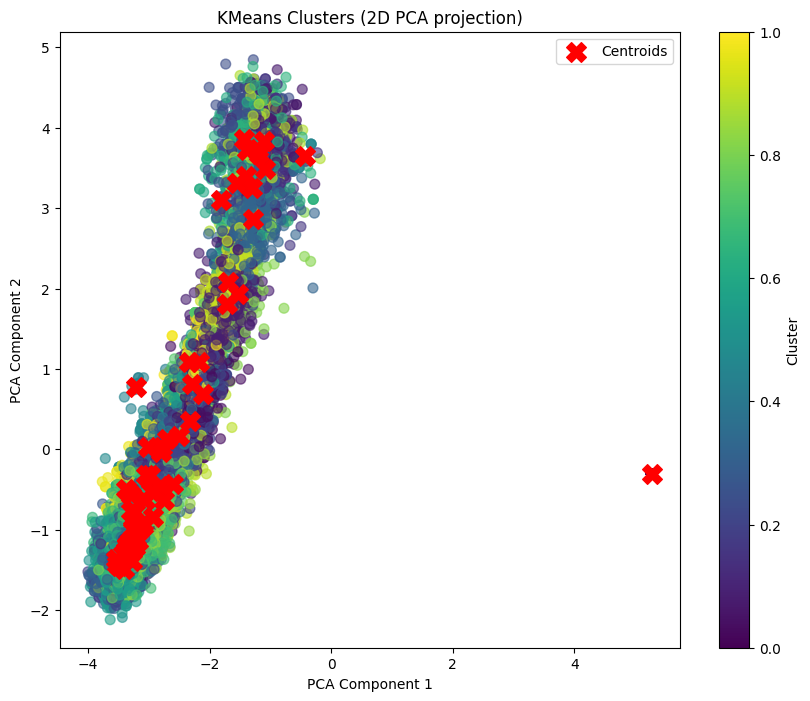

In [87]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce the dimensionality of the combined embeddings
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combined_emb_matrix)

# Plot the 2D representation of the clusters
plt.figure(figsize=(10, 8))

# Scatter plot for the reduced embeddings with color based on cluster assignments
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.6)

# Add cluster centroids to the plot
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label="Centroids")

# Add title and labels
plt.title('KMeans Clusters (2D PCA projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Show the color bar to indicate clusters
plt.colorbar(label='Cluster')

# Show plot
plt.legend()
plt.show()


In [67]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Convert Tier 1 embeddings and German descriptions into matrices
tier1_emb_matrix = list(tier1_embeddings.values())
german_desc_emb_matrix = np.array(german_desc_embeddings)

# Initialize KMeans with the number of clusters = number of distinct Tier 1 categories
num_clusters = len(tier1_embeddings)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit KMeans on the combined embeddings (Tier 1 and German descriptions)
combined_emb_matrix = np.vstack([tier1_emb_matrix, german_desc_emb_matrix])
kmeans.fit(combined_emb_matrix)

# Predict cluster assignments for German descriptions
cluster_assignments = kmeans.predict(german_desc_emb_matrix)

# Similarity-based cluster assignment
tier1_similarity_assignments = []
for german_desc_emb in german_desc_emb_matrix:
    # Calculate cosine similarity between the German description and all Tier 1 embeddings
    similarities = cosine_similarity([german_desc_emb], tier1_emb_matrix)[0]
    # Assign to the Tier 1 cluster with the highest similarity
    tier1_similarity_assignments.append(np.argmax(similarities))

# Calculate overlap metric (percentage of matching cluster assignments)
overlap_count = sum([1 for kmeans_cluster, similarity_cluster in zip(cluster_assignments, tier1_similarity_assignments) if kmeans_cluster == similarity_cluster])
overlap_metric = overlap_count / len(german_desc_emb_matrix)

print(f"Cluster Overlap Metric: {overlap_metric:.2f}")


Cluster Overlap Metric: 0.01
